# Лабороторная работа 1. Линейная регрессия и факторный анализ

## Введение

## Цель работы
Изучение основ линейной регрессии, построение простейших моделей регрессии, проведение обучения модели на реальных данных и оценка её качество.
## Задачи

1. Загрузить датасет из репозитория (например, kaggle.com или аналогичных платформ).

2. Подготовить данные: провести первичный анализ, визуализировать распределение признаков и целевой переменной. 

3. Провести предобработку данных: удалить пропущенные значения, закодировать категориальные переменные (опционально), нормализовать признаки.

4. Построить матрицу корреляций. Сделать выводы о наличии мультиколлинеарности (расчет VIF-коэффициента).

5. Построить регрессионные модели (линейная и гребневая). Если целевая переменная - категориальная, то исследовать логистическую регрессию. Разделить на тренировочную и тестовую выборки (80/20 или 70/30). Использовать кросс-валидацию. Оценить качество построенной модели с помощью метрик: RMSE (Root Mean Square Error), R² (коэффициент детерминации) и MAPE (Mean Absolute Percentage Error).

6. Устранить мультиколлинеарность и снизить размерность признаков с помощью метода главных компонент (PCA).

7. Повторить шаг 5 (линейная и гребневая регрессия), но использовать в качестве признаков не исходные данные, а главные компоненты. Сравнить метрики качества (RMSE, R² и MAPE) моделей, обученных на исходных данных и на главных компонентах.

## Ход работы

### 1. Выбор и загрузка датасета
В качестве датасета для анализа был выбран [Car Sales Dataset: Model, Features, and Pricing](https://www.kaggle.com/datasets/msnbehdani/mock-dataset-of-second-hand-car-sales)

Пример записей из датасета:


In [66]:
import math
import pandas as pd
import pingouin as pg
import seaborn as sns
import matplotlib.pyplot as plt


data = pd.read_csv('housing.csv')
print(data.head())

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                  41          880           129.0   
1    -122.22     37.86                  21         7099          1106.0   
2    -122.24     37.85                  52         1467           190.0   
3    -122.25     37.85                  52         1274           235.0   
4    -122.25     37.85                  52         1627           280.0   

   population  households  median_income ocean_proximity  median_house_value  
0         322         126         8.3252        NEAR BAY              452600  
1        2401        1138         8.3014        NEAR BAY              358500  
2         496         177         7.2574        NEAR BAY              352100  
3         558         219         5.6431        NEAR BAY              341300  
4         565         259         3.8462        NEAR BAY              342200  


Удаление записей с пропущенными значениями. Определени размера датасета:

In [67]:
data_clean = data.dropna()
data_clean = data_clean[['housing_median_age','total_rooms','population', 'median_income', 'median_house_value']]
print("Dataset records:", data_clean.shape[0])
print("Missed value:")
print(data_clean.isnull().sum())

Dataset records: 20433
Missed value:
housing_median_age    0
total_rooms           0
population            0
median_income         0
median_house_value    0
dtype: int64


### 2. Подготовка данных и первичный анализ
Определим количество интервалов для построения гистограмм по формуле стержиса


In [68]:
n = int(math.ceil(1 + math.log2(data_clean.shape[0])))

#### Первичный анализ и визуализации для параметра housing_median_age

mode: 0    52
Name: housing_median_age, dtype: int64
count    20433.000000
mean        28.633094
std         12.591805
min          1.000000
25%         18.000000
50%         29.000000
75%         37.000000
max         52.000000
Name: housing_median_age, dtype: float64
skew:  0.06160542582986426
kurtosis:  -0.8010133430522033


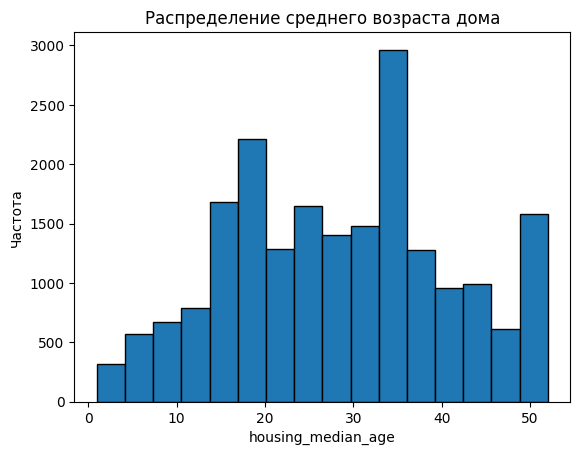

In [69]:
print('mode:', data_clean['housing_median_age'].mode())
print(data_clean['housing_median_age'].describe())
print('skew: ', data_clean['housing_median_age'].skew())
print('kurtosis: ', data_clean['housing_median_age'].kurtosis())


plt.hist(data_clean['housing_median_age'], bins=n, edgecolor='black')
plt.title('Распределение среднего возраста дома')
plt.xlabel('housing_median_age')
plt.ylabel('Частота')
plt.show()

#### Первичный анализ и визуализации для параметра population

mode: 0    891
Name: population, dtype: int64
count    20433.000000
mean      1424.946949
std       1133.208490
min          3.000000
25%        787.000000
50%       1166.000000
75%       1722.000000
max      35682.000000
Name: population, dtype: float64
skew:  4.96001654238539
kurtosis:  74.06088815431364


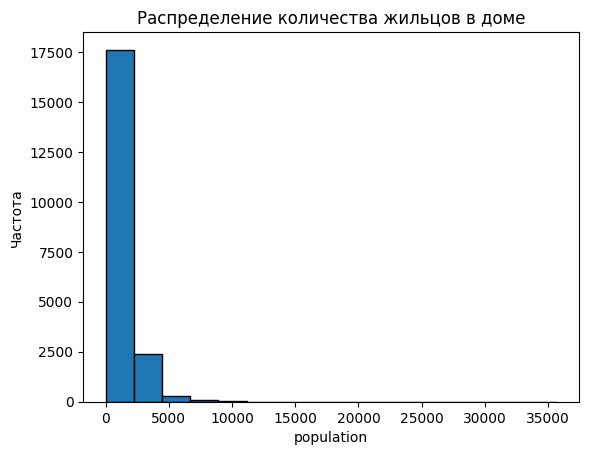

In [70]:
print('mode:', data_clean['population'].mode())
print(data_clean['population'].describe())
print('skew: ', data_clean['population'].skew())
print('kurtosis: ', data_clean['population'].kurtosis())

plt.hist(data_clean['population'], bins=n, edgecolor='black')
plt.title('Распределение количества жильцов в доме')
plt.xlabel('population')
plt.ylabel('Частота')
plt.show()

#### Первичный анализ и визуализации для параметра median_income

mode: 0    3.125
Name: median_income, dtype: float64
count    20433.000000
mean         3.871162
std          1.899291
min          0.499900
25%          2.563700
50%          3.536500
75%          4.744000
max         15.000100
Name: median_income, dtype: float64
skew:  1.6445569163060263
kurtosis:  4.943141124653197


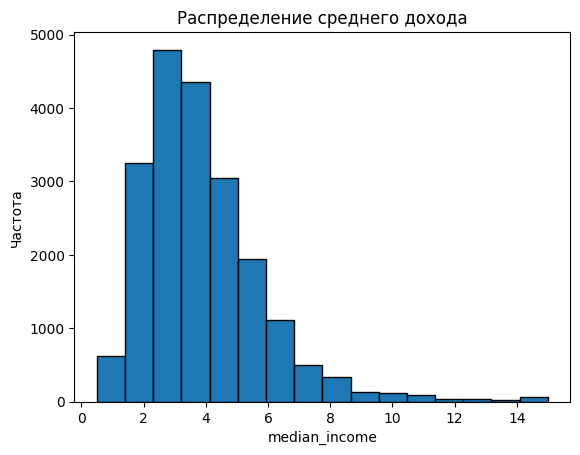

In [71]:
print('mode:', data_clean['median_income'].mode())
print(data_clean['median_income'].describe())
print('skew: ', data_clean['median_income'].skew())
print('kurtosis: ', data_clean['median_income'].kurtosis())

plt.hist(data_clean['median_income'], bins=n, edgecolor='black')
plt.title('Распределение среднего дохода')
plt.xlabel('median_income')
plt.ylabel('Частота')
plt.show()

#### Первичный анализ и визуализации для параметра total_rooms

mode: 0    1527
Name: total_rooms, dtype: int64
count    20433.000000
mean      2636.504233
std       2185.269567
min          2.000000
25%       1450.000000
50%       2127.000000
75%       3143.000000
max      39320.000000
Name: total_rooms, dtype: float64
skew:  4.15881642276731
kurtosis:  32.71385940059974


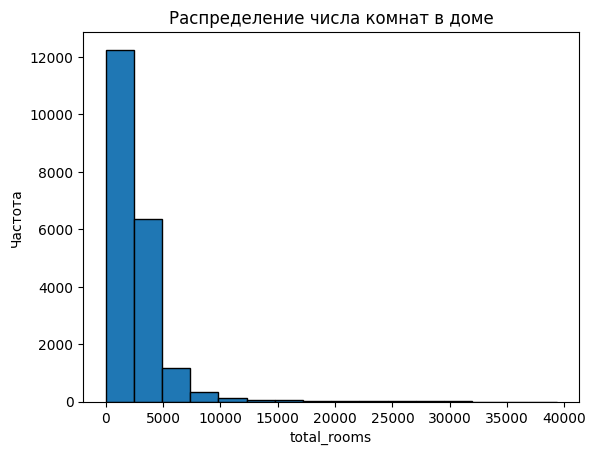

In [72]:
print('mode:', data_clean['total_rooms'].mode())
print(data_clean['total_rooms'].describe())
print('skew: ', data_clean['total_rooms'].skew())
print('kurtosis: ', data_clean['total_rooms'].kurtosis())

plt.hist(data_clean['total_rooms'], bins=n, edgecolor='black')
plt.title('Распределение числа комнат в доме')
plt.xlabel('total_rooms')
plt.ylabel('Частота')
plt.show()

#### Первичный анализ и визуализации для параметра median_house_value

mode: 0    500001
Name: median_house_value, dtype: int64
count     20433.000000
mean     206864.413155
std      115435.667099
min       14999.000000
25%      119500.000000
50%      179700.000000
75%      264700.000000
max      500001.000000
Name: median_house_value, dtype: float64
skew:  0.9782898908925552
kurtosis:  0.3280374703246349


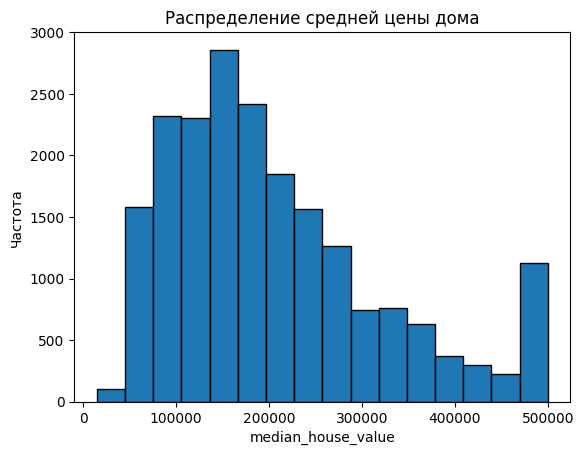

In [73]:
print('mode:', data_clean['median_house_value'].mode())
print(data_clean['median_house_value'].describe())
print('skew: ', data_clean['median_house_value'].skew())
print('kurtosis: ', data_clean['median_house_value'].kurtosis())

plt.hist(data_clean['median_house_value'], bins=n, edgecolor='black')
plt.title('Распределение средней цены дома')
plt.xlabel('median_house_value')
plt.ylabel('Частота')
plt.show()

## 4. Построение матрицы корреляции
Коэфициент корреляции Пирсона
\[ 
r = \frac{\sum_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n} (x_i - \bar{x})^2} \cdot \sqrt{\sum_{i=1}^{n} (y_i - \bar{y})^2}} 
\]

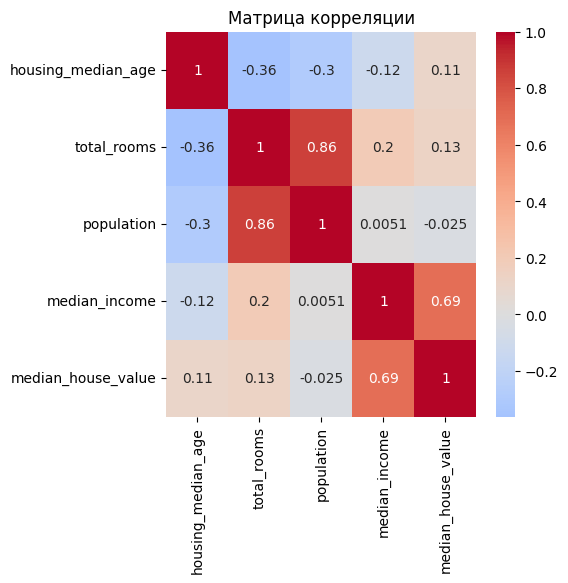

In [75]:
corr_matrix = data_clean.corr()
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляции')
plt.show()

#### Рассчет VIF